<a href="https://colab.research.google.com/github/Jeremy-su1/VLMs/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision-Language Models of the Multi-Modal
## **CLIP**

## Review of CLIP paper

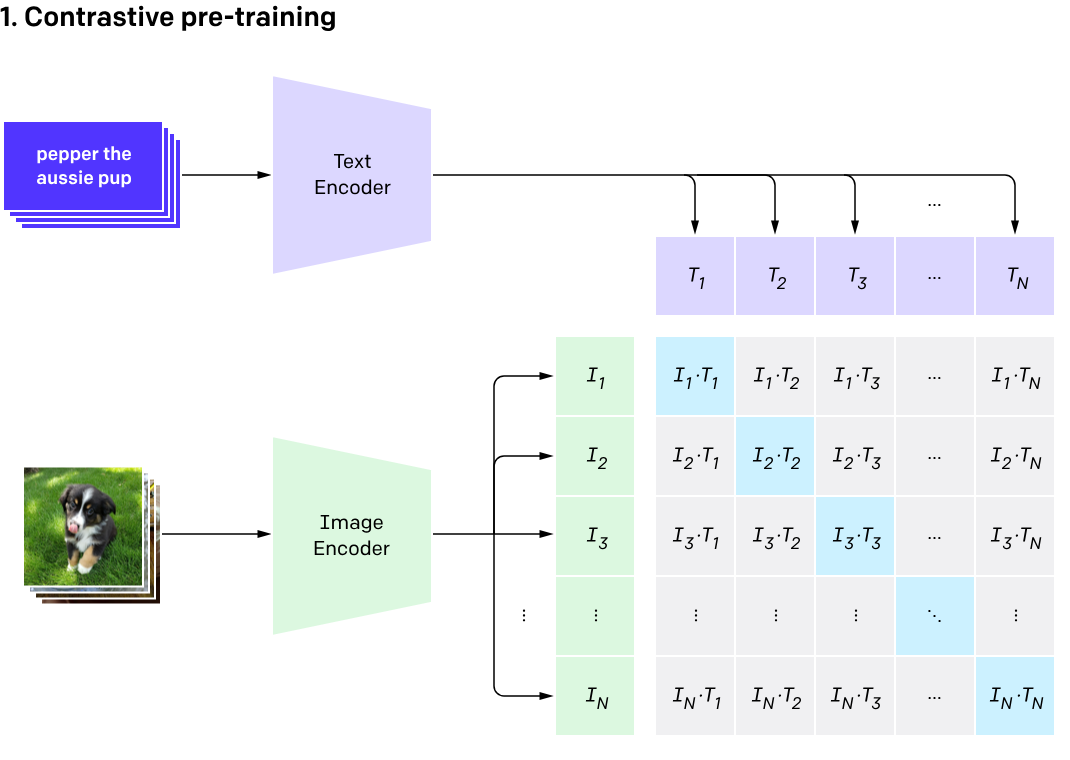

https://openai.com/index/clip/


## **CLIP.ipynb 실습 목적 및 전체 코드 흐름**
*코드 실습 목적*
- CLIP 모델의 기본 동작 원리
- zero-shot transfer 방식 확인

*코드 흐름*
1. 환경 설정 및 라이브러리 설치  
  . CLIP모델을 Github에서 설치하고, 필요한 라이브러리(Pytorch, clip, PIL, matplotlib 등)를 load  
  . GPU 확인
2. Dataset 준비  
  . 두 개의 샘플 Image를 다운로드하여 리스트로 저장  
  . example text prompt(class label)를 정의  
3. CLIP 모델 불러오기  
  . 사전 학습된 ViT-B/32 모델과 해당 전처리 함수를 로드  
4. 전처리 및 임베딩 추출  
  . Image는 CLIP 전처리(preprocess)를 적용하여 tensor로 변환하고, text는 tokenize를 사용  
5. Cosine 유사도 계산 및 예측  
  . Image & Text Embedding간의 내적을 계산하여 유사도(logits)를 구한 후, softmax로 확률 분포를 생성  
  . 각 Image에 대해 가장 높은 확률을 가진 text prompt 예측  
6. 결과 시각화  
  . 각 Image와 함께 예측 결과(Class 및 확률)를 시각적으로 출력  
  . Image-Text 유사도 행렬을 히트맵 형태로도 시각화  
7. [확장] Prompt Engineering   
  . 기존 prompt 외에도 다양한 변형 프롬프트를 추가하여 동일 Image에 대해 예측 결과 비교  


# Section 1. Install the python Library

In [8]:
#@title ##1-1.Check the Python version in colab
# import the sys module
# sys 모듈은 파이썬 인터프리터와 관련된 함수와 변수들을 제공
import sys

# 현재 파이썬 인터프리터의 버전 정보를 출력
sys.version


'3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]'

In [9]:
# Google Drive approach
# Durations: 20s
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#@title ##1-2. Install the python library
# Durations: 1 minutes

# CLIP library를 GitHub에서 직접 설치
%pip install git+https://github.com/openai/CLIP.git

# PyTorch library: 딥러닝 모델 구축과 학습을 위한 library
import torch

# CLIP library: CLIP 모델과 관련 함수 제공
import clip

# PIL(Python Imaging Library): 이미지 처리 library
from PIL import Image

# requests: URL을 통해 데이터를 가져오기 위한 HTTP library
import requests

# BytesIO: 바이트 데이터를 파일 객체처럼 다룰 수 있게 해주는 모듈 (이미지 다운로드 후 처리에 사용)
from io import BytesIO

# matplotlib: 데이터 시각화를 위한 library
import matplotlib.pyplot as plt

# numpy: 수치 계산 및 배열 조작을 위한 library
import numpy as np


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-40s7tj1x
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-40s7tj1x
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


참고 사항
```python
%pip install git+https://github.com/openai/CLIP.git
```
VS.
```python
from transformers import CLIPProcessor, CLIPModel
```
OpenAI 공식 CLIP 라이브러리 VS. HuggingFace Transformers의 CLIP
> OpenAI 공식 CLIP 라이브러리 (GitHub)  
> OpenAI에서 직접 개발한 원본 구현체로, CLIP 모델의 학습, 추론, 전처리 함수 등이 포함  
> 코드가 비교적 간결, 연구 목적이나 실험을 위해 모델 구조를 직접 수정 가능  
> 원본 구현체이기 때문에 논문에 나온 세부 구현 방식과 유사하게 동작  

> HuggingFace Transformers의 CLIP (CLIPProcessor, CLIPModel)  
> HuggingFace의 Transformers 라이브러리 내에 통합된 버전, 다양한 모델과 동일한 API로 CLIP사용   
> CLIPProcessor는 Image와 Text 전처리를 일관되게 처리해주며, CLIPModel은 모델 추론 및 임베딩 추출 기능을 제공  
> HuggingFace Hub와 연동하여 사전 학습된 모델 가중치를 load할 수 있고, 다른 모델과 함께 파이프라인으로 사용할 수 있음  
> https://huggingface.co/docs/transformers/main/en/model_doc/clip

*Summary*
두 library 모두 동일한 CLIP 모델을 기반으로 하지만, OpenAI library는 원본 구현체로 모델의 내부를 수정하고, 실습할 수 있도록 가능하게 한 것이고, Transformers library는 보다 통합된 API와 편리한 사용성을 제공하여 다양한 모델과 함께 활용할 수 있음.

In [11]:
# 현재 Colab에서 GPU 사용 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


# Section 2. Prepare the Dataset

In [12]:
#@title ## 2-1. Image load function
# Define a list of image URLs
image_urls = [
    "https://images.unsplash.com/photo-1518791841217-8f162f1e1131?ixlib=rb-1.2.1",
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d?ixlib=rb-1.2.1"
]

<left>[CAT]<img src="https://images.unsplash.com/photo-1518791841217-8f162f1e1131?ixlib=rb-1.2.1" width="400"/></left>[DOG]<right><img src="https://images.unsplash.com/photo-1518717758536-85ae29035b6d?ixlib=rb-1.2.1" width="400"/></right>

In [13]:
# a function to download an image from a URL
def load_image(url):
  response = requests.get(url)  # Send a GET request to the image URL
  return Image.open(BytesIO(response.content)).convert("RGB")
  # Open the image from the response content and convert to RGB

# Load images by applying the load_image function to each URL in the image_urls list
images = [load_image(url) for url in image_urls]

In [14]:
#@title ##2-2. Install the python library
# Define the Text prompt for test
text_prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a bird",
    "a photo of a car"
]

# Section 3. Load the CLIP Model

*Load model*
ViT-B/32: Vision Transformer(ViT) 기반으로, 32*32 패치 크기를 사용  

*clip.load function*  
clip.load는 2가지 값을 반환  
- 모델 객체(model): Image encoder와 Text encoder를 모두 포함한 CLIP 모델
- 전처리 함수(preprocess): 모델에 입력되는 이미지를 모델이 요구하는 형식으로 변환하는 function. 즉, Image resize, normalization, central crop 등의 작업을 수행



*Model Training and Evaluation*  
PyTorch 모델은 2가지 주요 모드를 제공(train, eval)  
1. Train Mode(model.train())  
- 목적: 모델을 학습(Training) 상태로 설정
- 특징:
  - 드롭아웃(Dropout): 일부 뉴런을 임의로 비활성화하여 과적합(overfitting)을 방지
  - 배치 정규화(Batch Normalization): 미니배치의 통계값(평균, 분산)을 사용하여 정규화
- 사용 시점: 모델을 학습할 때, 가중치 업데이트 전 과정에서 사용

2. Eval mode(model.eval())
- 목적: 모델을 평가(Evaluation) 상태로 설정
- 특징:
  - 드롭아웃 비활성화: 모든 뉴런이 활성화되어 결정론적(deterministic) 출력을 제공합니다.
  - 배치 정규화: 학습 중에 계산된 이동 평균(전역 통계)을 사용하여 정규화
- 사용 시점: 모델 추론(Inference)이나 테스트 단계에서 사용

In [15]:
#@title ## 3-1. load the clip model(encoder)

# Load the pre-trained CLIP model (ViT-B/32) along with its preprocessing function,
# which in cludes both the image encoder and the text encoder
model, preprocess = clip.load("ViT-B/32", device=device)

# Set the model to evaluation mode to disable dropout and other training-specific behaviors.
model.eval()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 136MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [16]:
#@title ## 3-2. model diagram
%pip install torchinfo

from torchinfo import summary

model.visual = model.visual.float()

summary(model.visual, input_size=(1,3,224,224))
# input_size(batch size, channel, height, width)
# batch size: 한 번에 하나의 이미지가 입력된다는 의미
# channel: RGB
# image size : height, width

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 512]                  432,384
├─Conv2d: 1-1                                 [1, 768, 7, 7]            2,359,296
├─LayerNorm: 1-2                              [1, 50, 768]              1,536
├─Transformer: 1-3                            [50, 1, 768]              --
│    └─Sequential: 2-1                        [50, 1, 768]              --
│    │    └─ResidualAttentionBlock: 3-1       [50, 1, 768]              7,087,872
│    │    └─ResidualAttentionBlock: 3-2       [50, 1, 768]              7,087,872
│    │    └─ResidualAttentionBlock: 3-3       [50, 1, 768]              7,087,872
│    │    └─ResidualAttentionBlock: 3-4       [50, 1, 768]              7,087,872
│    │    └─ResidualAttentionBlock: 3-5       [50, 1, 768]              7,087,872
│    │    └─ResidualAttentionBlock: 3-6       [50, 1, 768]              7,087,872
│    │    └─ResidualAttentionBlock: 3-

# Section 4. 이미지 및 텍스트 전처리 및 임베딩 추출

In [17]:
#@title ## 4-1. Image Preprocess
# 이미지 전처리: CLIP의 preprocess함수를 사용하여 이미지 변환
# Apply CLIP's preprocess function to each image in the 'images' list.
# The preprocess function handles resizing, cropping, normalization, etc.
# torch.stack combines the preprocessed images into a single batch tensor.
# Finally, .to(device) moves the tensor to the GPU device
preprocessed_images = torch.stack([preprocess(img) for img in images]).to(device)

```python
[preprocess(img) for img in images]
```
- preprocess 함수는 CLIP 모델을 로드할 때 함께 반환된 함수, CLIP에 적합한 방식으로 이미지를 전처리
  - 이미지의 크기를 조정, 중앙 크롭, 정규화 등 필요한 변환을 수행하여 모델이 기대하는 형태(보통 PyTorch 텐서, 특정 크기와 정규화된 픽셀 값)로 저장

```python
torch.stack
```
- torch.stack은 리스트에 있는 여러 텐서를 하나의 새로운 텐서로 결합
- 전처리된 이미지 텐서는 보통 [C,H,W] 형태를 지님 -> 이들을 stack하면 [N,C,H,W] 형태의 배치 텐서가 생성

*Summary*
- 목적: 여러 개의 이미지(리스트 형태)를 전처리하여 각각 tensor로 변환하고, 이를 하나의 배치 tensor로 결합 한후, 모델이 사용 가능한 device로 이동
- 결과: preprocessed_images 변수에는 [N,C,H,W]형태의 tensor가 저장. 이는 CLIP의 이미지 encoder에 바로 입력할 수 있는 형태가 됨.


In [18]:
#@title ## 4-2. Clip tokenize
# 텍스트 전처리: CLIP의 tokenize 함수를 사용
tokenized_text = clip.tokenize(text_prompts).to(device)

In [19]:
# Extract image and text embeddings using CLIP's encoders.
# The no_grad context is used to disable gradient calculations for inference,
# reducing memory usage and improving speed.
model = model.float()
with torch.no_grad():
    # Pass the preprocessed images through the image encoder.
    # Returns a tensor of shape [n, d_i] where n is the number of images
    # and d_i is the dimensionality of the image embeddings.
    image_features = model.encode_image(preprocessed_images)

    # Pass the tokenized text through the text encoder.
    # Returns a tensor of shape [num_prompts, d_t] where num_prompts is the number
    # of text queries and d_t is the dimensionality of the text embeddings.
    text_features = model.encode_text(tokenized_text)


```python
torch.no_grad()
```
- train mode가 아닌 eval 단계에서는 gradient 계산이 필요없음


image_features
```
model.encode_image(preprocessed_images)
```
위 호출을 통해 전처리된 이미지 배치를 이미지 인코더에 통과시켜 임베딩 벡터를 생성.  
[n,d_i] 형태의 텐서로 return된다(n: 이미지 개수, d_i: 이미지 임베딩 차원)

text_features
```
model.encode_text(tokenized_text)
```
호출을 통해 토큰화된 텍스트 데이터를 텍스트 인코더에 입력하여 임베딩 벡터를 생성.  
[num_prompts, d_t] 형태의 텐서로 return된다(num_prompts: 텍스트 프롬프트의 개수, d_t: 텍스트 임베딩의 차원)


In [20]:
# L2 normalize the image feature vectors so that each has unit norm
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
# L2 normalize the text feature vectors so that each has unit norm
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

image_features와 text_features를 L2 normalization하여 벡터의 크기를 1로 맞추는 과정
```
.norm(dim=-1, keepdim=True)
```
마지막 차원(dim=-1)을 따라서 벡터의 L2 norm을 계산
keepdim 옵션은 연산 후에도 차원 수를 유지하여 broadcast 연산이 가능하도록 함.  
 * norm에 대한 이론: https://jeremy-su1.github.io/ml/deeplearning/nlp/norm/
  
임베딩 벡터를 norm으로 나누면, 모든 벡터가 크기 1을 가지게 되며 방향에 대한 정보만 남게 됨.
이렇게 정규화된 벡터끼리 cosine similarity를 계산하면, 두 벡터 간의 방향 차이만 반영되므로 내적이 곧 cosine similarity가 됨
**cosine similarity를 활용하는 CLIP의 contrastive learning이나 reranking 과정에서, 이 L2 normalization는 서로 다른 길이의 벡터가 크기 차이 때문에 영향을 받지 않도록 보장해줌.**

# Section 5. 코사인 유사도 계산 및 Zero-shot 예측

In [21]:
#@title ## 5-1. Logits per Image
# Compute the cosine similarity between each image and each text embedding
# by taking the dot product of normalized image_features and transposed text_features.
# This yields a (num_images * num_prompts) matrix of logits.
logits_per_image = image_features @ text_features.t()

정규화된 이미지 임베딩(image_features)과 정규화된 텍스트 임베딩(text_features) 간의 cosine similarity를 계산  
image_features의 크기 = [n,d] (n = num_images, d = dim)
text_features의 크기 = [m,d] (m = num_propmts, d = dim)

text_features.t()를 통해 [d,m]형태로 transpose한 뒤 연산을 수행하면, [n,m] 크기의 logit 행렬이 생성  
[n,m]의 logit 행렬이 주는 의미  
 **n번째의 이미지와 m번째 텍스트 간의 코사인 유사도를 나타냄**  


In [22]:
# Convert the logits to a probability distribution over text prompts
# by applying softmax along the last dimension (over prompts).
probs = logits_per_image.softmax(dim=-1).cpu().numpy()

logits_per_image 행렬을 확률 분포로 변환하는 과정  
[softmax]   
![image.png](https://miro.medium.com/v2/resize:fit:960/format:webp/1*5nKWsukS6lPR-7fHtlK2Rg.png)

In [23]:
# Iterate over each image’s probability vector
for i, prob in enumerate(probs):
    # Find the index of the highest probability
    top_idx = np.argmax(prob)
    # Print the image number, predicted prompt, and its associated probability
    print(f"Image {i+1} 예측: {text_prompts[top_idx]} (확률: {prob[top_idx]:.4f})")

Image 1 예측: a photo of a cat (확률: 0.2642)
Image 2 예측: a photo of a dog (확률: 0.2648)


```
enumerate(probs)
```
probs는 각 image마다, 각각의 text prompt에 대한 확률분포를 담고 있음.
enumerate로 순서(i)와 확률 벡터(prob)를 가지고 옴.  
```
np.argmax(prob)
```
확률에서 가장 큰 값의 인덱스를 찾는 과정

# Section 6. 결과 시각화

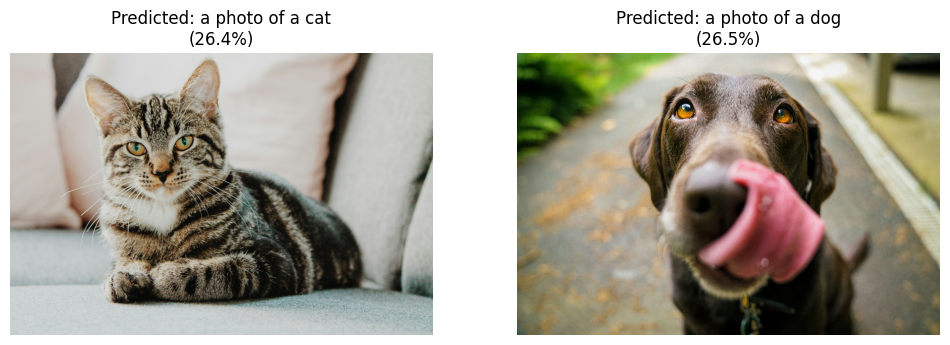

In [24]:
# 각 이미지와 함께 각 텍스트 프롬프트에 대한 확률을 히트맵 형태로 시각화
fig, ax = plt.subplots(1, len(images), figsize=(12, 6))
if len(images) == 1:
    ax = [ax]
for idx, (img, prob) in enumerate(zip(images, probs)):
    ax[idx].imshow(img)
    ax[idx].axis("off")
    # 예측 결과를 제목으로 표시 (가장 높은 확률의 프롬프트)
    top_idx = np.argmax(prob)
    ax[idx].set_title(f"Predicted: {text_prompts[top_idx]}\n({prob[top_idx]*100:.1f}%)")
plt.show()

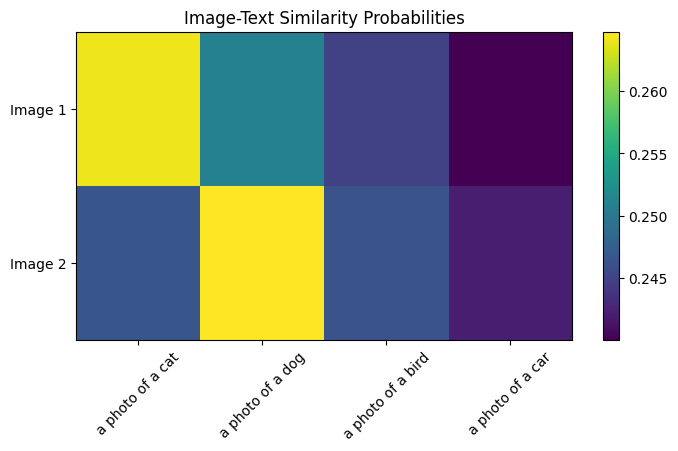

In [25]:
# 추가: 확률 행렬 히트맵 시각화
plt.figure(figsize=(8, 4))
plt.imshow(probs, aspect="auto", cmap="viridis")
plt.colorbar()
plt.yticks(ticks=range(len(images)), labels=[f"Image {i+1}" for i in range(len(images))])
plt.xticks(ticks=range(len(text_prompts)), labels=text_prompts, rotation=45)
plt.title("Image-Text Similarity Probabilities")
plt.show()


# Section 7. 프롬프트 엔지니어링 실습

In [26]:
# 다양한 프롬프트를 사용하여 동일 이미지를 예측해보고 결과 비교
alternative_prompts = [
    "a close-up photo of a cat",
    "a small photo of a cat",
    "a photo of a cute cat",
    "a picture of a cat in the wild"
]

In [27]:
# 기존 텍스트 프롬프트에 추가하여 새로운 리스트 구성
extended_prompts = text_prompts + alternative_prompts

# 텍스트 토큰화 및 임베딩 추출
extended_tokenized_text = clip.tokenize(extended_prompts).to(device)
with torch.no_grad():
    extended_text_features = model.encode_text(extended_tokenized_text)
extended_text_features = extended_text_features / extended_text_features.norm(dim=-1, keepdim=True)


In [28]:
# 새로운 텍스트 임베딩과 이미지 임베딩을 비교
logits_extended = image_features @ extended_text_features.t()
probs_extended = logits_extended.softmax(dim=-1).cpu().numpy()


In [29]:
print("\n프롬프트 엔지니어링 결과 (확장 프롬프트 포함):")
for i, prob in enumerate(probs_extended):
    top_idx = np.argmax(prob)
    print(f"Image {i+1} 예측: {extended_prompts[top_idx]} (확률: {prob[top_idx]:.4f})")


프롬프트 엔지니어링 결과 (확장 프롬프트 포함):
Image 1 예측: a photo of a cute cat (확률: 0.1294)
Image 2 예측: a photo of a dog (확률: 0.1335)


# Section 8. meme Image 테스트

https://en.wikipedia.org/wiki/Italian_brainrot


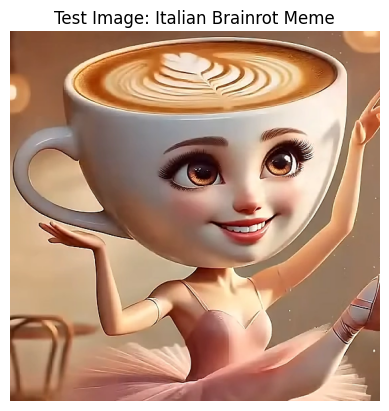

In [42]:
# 이탈리아 브레인로트 밈 이미지 테스트
#meme_url = "https://upload.wikimedia.org/wikipedia/commons/f/f6/Tralalero_Tralala.webp"
meme_url = "https://upload.wikimedia.org/wikipedia/commons/6/6c/Ballerina_Cappuccina.png"
meme_image = Image.open(requests.get(meme_url, stream=True).raw)

plt.imshow(meme_image)
plt.axis("off")
plt.title("Test Image: Italian Brainrot Meme")
plt.show()

In [43]:
meme_texts = [
    # "a photo of a dog",
    # "a funny meme",
    # "an Italian explosion of style",
    # "confusing and chaotic visual humor",
    #"a normal image"
    "a photo of a ballerina in a cafe",
    "an Italian style AI-generated meme with espresso and fashion",
    "a chaotic collage of Italian stereotypes",
    "a surreal fashion editorial with coffee and neon signs"
]

In [44]:
meme_image_input = preprocess(meme_image).unsqueeze(0).to(device)
meme_text_tokens = clip.tokenize(meme_texts).to(device)

In [45]:
with torch.no_grad():
    meme_image_features = model.encode_image(meme_image_input)
    meme_text_features = model.encode_text(meme_text_tokens)

    meme_image_features /= meme_image_features.norm(dim=-1, keepdim=True)
    meme_text_features /= meme_text_features.norm(dim=-1, keepdim=True)

    meme_similarity = (100.0 * meme_image_features @ meme_text_features.T).softmax(dim=-1)


In [46]:
# 결과 출력
print("\n🎭 Meme Image Prediction:")
for i, text in enumerate(meme_texts):
    print(f"{text:<40s}: {meme_similarity[0][i].item():.4f}")


🎭 Meme Image Prediction:
a photo of a ballerina in a cafe        : 0.9151
an Italian style AI-generated meme with espresso and fashion: 0.0469
a chaotic collage of Italian stereotypes: 0.0000
a surreal fashion editorial with coffee and neon signs: 0.0380
